### Walmart Sales Forecasting - Using LSTM

In [32]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#### Data Preprocessing

In [33]:
# importing the dataset

df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [34]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [35]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst = True)
df = df.drop_duplicates(subset='Date', keep='first')
df.set_index('Date',inplace= True)
df = df.resample('W-FRI').sum()
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [36]:
df = df[['Weekly_Sales']]
df.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


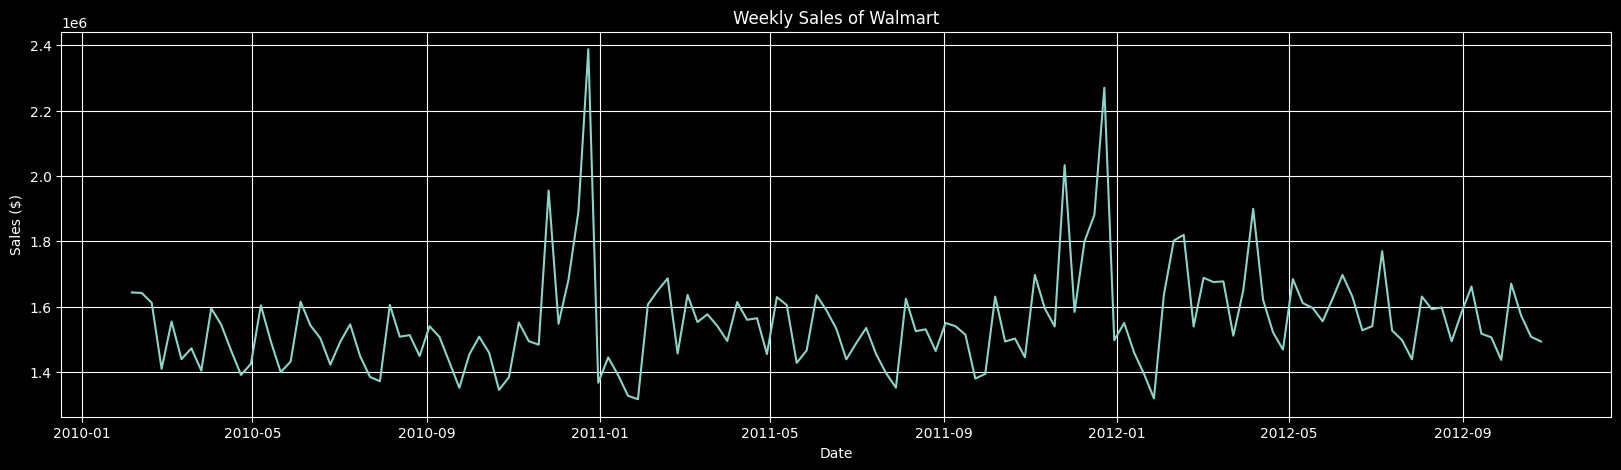

In [37]:
# plotting Weekly sales

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.title('Weekly Sales of Walmart')
plt.grid()
plt.show()

#### Seasonality test

<Figure size 2000x500 with 0 Axes>

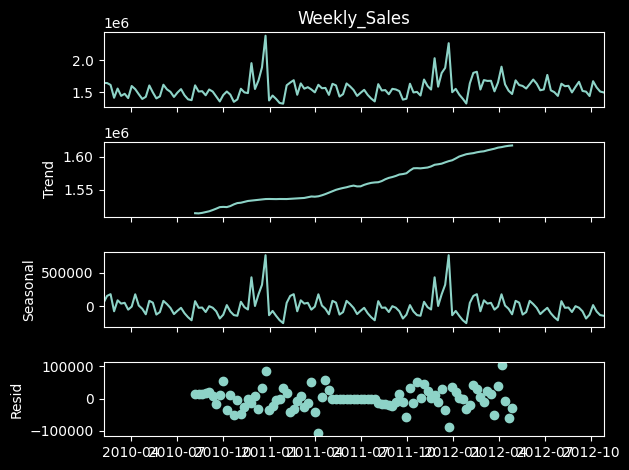

In [38]:
# seasonality check

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(20,5))
snl = seasonal_decompose(df['Weekly_Sales'])
snl.plot()
plt.show()

#### Train / Test split

In [39]:
len(df)

143

In [40]:
train_size = int(len(df)*0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

print(f'Train dataset shape: {df_train.shape}')
print(f'Test dataset shape: {df_test.shape}')

Train dataset shape: (114, 1)
Test dataset shape: (29, 1)


#### Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(df_train)

scaled_train = scaler.transform(df_train)

scaled_test = scaler.transform(df_test)

scaled_train[:10]

array([[0.30511304],
       [0.30349457],
       [0.27549472],
       [0.08667028],
       [0.22212518],
       [0.11450649],
       [0.14529326],
       [0.08172404],
       [0.25962256],
       [0.21335982]])

In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 52
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size = 1)

print(len(scaled_train), len(generator))

114 62


In [43]:
x,y = generator[0]

print(f'Given the Array \n{x.flatten()}')
print(f'Predict this y \n{y}')

Given the Array 
[0.30511304 0.30349457 0.27549472 0.08667028 0.22212518 0.11450649
 0.14529326 0.08172404 0.25962256 0.21335982 0.13926413 0.06942416
 0.10102358 0.26801323 0.16558708 0.07727248 0.1075305  0.27881532
 0.21069193 0.17402044 0.09879296 0.16387534 0.21397197 0.12328043
 0.06364393 0.05143293 0.26944795 0.17864553 0.183167   0.12347089
 0.20845342 0.17792001 0.10595142 0.03257709 0.12737975 0.17864755
 0.13305604 0.02666044 0.06284474 0.21918657 0.16579995 0.15581414
 0.59635336 0.21580158 0.34145432 0.53604887 1.         0.04707591
 0.11935284 0.06919807 0.00980916 0.        ]
Predict this y 
[[0.27051027]]


In [44]:
# define model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(100,activation ='relu',input_shape = (n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.fit(generator,epochs=50)

Epoch 1/50
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0357

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0256
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0293
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0198
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0328
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0182
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0264
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0272
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0260
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0179
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0266
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0260
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0127
Epoch 13/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0209
Epoch 14/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0145
Epoch 15/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0332
Epoch 16/50
62/62 

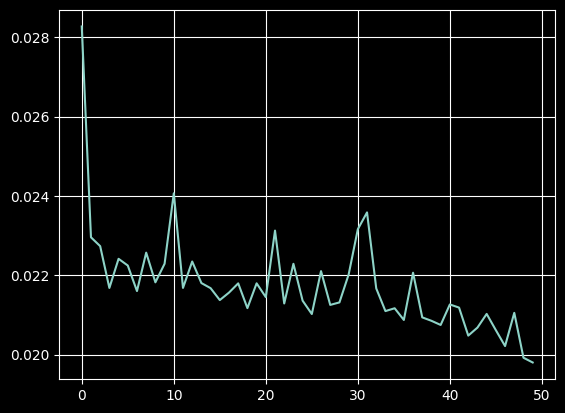

In [47]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.grid()

In [48]:
last_train_batch = scaled_train[-52:]
last_train_batch

array([[0.22687035],
       [0.23147406],
       [0.1290241 ],
       [0.29176202],
       [0.26877926],
       [0.10393433],
       [0.13925329],
       [0.29707188],
       [0.25400195],
       [0.20093868],
       [0.11384225],
       [0.16025268],
       [0.20349204],
       [0.12905144],
       [0.07471868],
       [0.03297741],
       [0.28708668],
       [0.19443313],
       [0.19967503],
       [0.13798985],
       [0.21785138],
       [0.20874072],
       [0.18426806],
       [0.05893367],
       [0.07251058],
       [0.29325464],
       [0.16490964],
       [0.17334701],
       [0.11983537],
       [0.35510009],
       [0.25959512],
       [0.20781869],
       [0.66889571],
       [0.24946027],
       [0.45075642],
       [0.52684458],
       [0.89005078],
       [0.16858528],
       [0.21798274],
       [0.13323537],
       [0.07235373],
       [0.00226533],
       [0.29824945],
       [0.45336606],
       [0.46960485],
       [0.20772918],
       [0.34687563],
       [0.334

In [49]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)
last_train_batch

array([[[0.22687035],
        [0.23147406],
        [0.1290241 ],
        [0.29176202],
        [0.26877926],
        [0.10393433],
        [0.13925329],
        [0.29707188],
        [0.25400195],
        [0.20093868],
        [0.11384225],
        [0.16025268],
        [0.20349204],
        [0.12905144],
        [0.07471868],
        [0.03297741],
        [0.28708668],
        [0.19443313],
        [0.19967503],
        [0.13798985],
        [0.21785138],
        [0.20874072],
        [0.18426806],
        [0.05893367],
        [0.07251058],
        [0.29325464],
        [0.16490964],
        [0.17334701],
        [0.11983537],
        [0.35510009],
        [0.25959512],
        [0.20781869],
        [0.66889571],
        [0.24946027],
        [0.45075642],
        [0.52684458],
        [0.89005078],
        [0.16858528],
        [0.21798274],
        [0.13323537],
        [0.07235373],
        [0.00226533],
        [0.29824945],
        [0.45336606],
        [0.46960485],
        [0

In [50]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


array([[0.2978518]], dtype=float32)

In [51]:
scaled_test[0]

array([0.28395699])

In [52]:
test_prediction =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(df_test)):
    current_prediction = model.predict(current_batch)[0]
    test_prediction.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

In [53]:
test_prediction

[array([0.2978518], dtype=float32),
 array([0.27731496], dtype=float32),
 array([0.26588455], dtype=float32),
 array([0.25735033], dtype=float32),
 array([0.2507776], dtype=float32),
 array([0.24561164], dtype=float32),
 array([0.24149546], dtype=float32),
 array([0.23818906], dtype=float32),
 array([0.23552293], dtype=float32),
 array([0.23337138], dtype=float32),
 array([0.23163716], dtype=float32),
 array([0.230243], dtype=float32),
 array([0.22912884], dtype=float32),
 array([0.22824265], dtype=float32),
 array([0.22754054], dtype=float32),
 array([0.22698659], dtype=float32),
 array([0.22655152], dtype=float32),
 array([0.22621125], dtype=float32),
 array([0.22594634], dtype=float32),
 array([0.22574098], dtype=float32),
 array([0.22558247], dtype=float32),
 array([0.22546068], dtype=float32),
 array([0.22536738], dtype=float32),
 array([0.22529627], dtype=float32),
 array([0.2252423], dtype=float32),
 array([0.22520147], dtype=float32),
 array([0.22517078], dtype=float32),
 array

In [54]:
df_test.head()

,Weekly_Sales
Date,
2012-04-13,1621031.70
2012-04-20,1521577.87
2012-04-27,1468928.37
2012-05-04,1684519.99
2012-05-11,1611096.05


In [55]:
true_predictions = scaler.inverse_transform(test_prediction)

In [56]:
df_test['Predictions'] = true_predictions

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21396\1855845338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predictions'] = true_predictions


In [57]:
df_test.head()

,Weekly_Sales,Predictions
Date,,
2012-04-13,1621031.70,1.635914e+06
2012-04-20,1521577.87,1.613918e+06
2012-04-27,1468928.37,1.601675e+06
2012-05-04,1684519.99,1.592535e+06
2012-05-11,1611096.05,1.585495e+06


<Axes: xlabel='Date'>

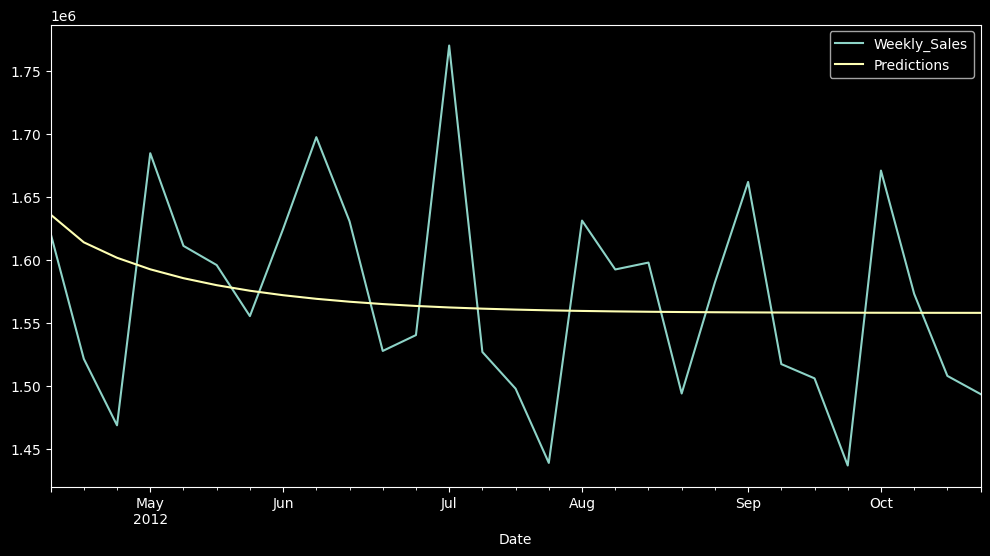

In [58]:
df_test.plot(figsize=(12,6))